
<h1 align=center><font size = 5> <center>文本分析与挖掘</center> </font></h1> 

<h2 align=center><font size = 4><center>期末综合作业</center></font></h2>
<h2 align=center><font size = 2><center>浙江工业大学计算机科学与技术学院</center></font></h2>

# 对文本进行适当的预处理

对报警情况和出警内容进行一些预处理后进行训练。

In [2]:
import jieba
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import unicodedata
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import re
from imblearn.over_sampling import SMOTE


In [2]:
np.set_printoptions(threshold=10000) #全显示

### 1.预训练

#### a. 加载数据

In [3]:
x_train_data=pd.read_excel('警情数据集/X_train.xlsx')
x_test_data=pd.read_excel('警情数据集/X_test.xlsx')

y_train_data=pd.read_excel('警情数据集/y_train.xlsx')
y=y_train_data['最终反馈警情类别']
y_test_data=pd.read_excel('警情数据集/y_test.xlsx')
y_test=y_test_data['最终反馈警情类别']

x=x_train_data['报警内容']+'。'+x_train_data['出警情况（反馈内容）']
x_test=x_test_data['报警内容']+'。'+x_test_data['出警情况（反馈内容）']

In [4]:
title_mapping = {"求助": 0, "治安案件": 1, "纠纷": 2, "举报": 3, "其它报警": 4,"刑事案件":5}#将标签对应数值
y= y.map(title_mapping)#处理数据
y = y.fillna(0).values##将其余标签填充为0值
y_test= y_test.map(title_mapping)#处理数据
y_test = y_test.fillna(0).values##将其余标签填充为0值



#### 查看文本

In [5]:
print("文本1：",x[0])
print("文本2：",x[1])

文本1： 事故后期，赔偿纠纷。2019年7月27日9时41分许，民警***带领辅警冯诚军，***到达萧山区靖江路与广场路西面100米，经了解系胡选学（1993********）称其与对方**水（1970********）因交通事故后赔偿产生纠纷，后经民警工作，其表示会自行协调处理，现已平息。
文本2： 称因感情问题，妹妹扬言要自杀  已通知120。民警***带领辅警**、***、**到达二桥村327号报警现场，经了解报警人***（男：1999********电话：183********）称其妹妹***（女：浙江省仙居县人 14岁 电话：135********）因感情问题，情绪比较激动（未有自杀行为）。民警现场了解情况后经劝说，等***情绪平复下来，由***的母亲***（女：浙江省仙居县人 51岁 电话：155********）看管照顾。（警务通）值班民警：***


<div class="alert alert-success alertsuccess" style="margin-top: 10px">
查看文本，有大量的无用字符"*"，而且括号中的信息多为身份信息、日期和电话等，也对分类无效，应当进行清除

In [6]:
x_doc = x.apply(lambda x: re.sub("[0-9]+|年|月|日|时|分|、|。|，|：|:|[*]|（.*?）|{.*?}|[.*?]|【.*?】", "",x))
x_test_doc = x_test.apply(lambda x: re.sub("[0-9]+|年|月|日|时|分|、|。|，|：|:|[*]|（.*?）|{.*?}|[.*?]|【.*?】", "",x))

#### 查看清洗后的文本

In [7]:
print("清洗文本1：",x_doc[0])
print("清洗文本2：",x_doc[1])

清洗文本1： 事故后期赔偿纠纷许民警带领辅警冯诚军到达萧山区靖江路与广场路西面米经了解系胡选学称其与对方水因交通事故后赔偿产生纠纷后经民警工作其表示会自行协调处理现已平息
清洗文本2： 称因感情问题妹妹扬言要自杀  已通知民警带领辅警到达二桥村号报警现场经了解报警人称其妹妹因感情问题情绪比较激动民警现场了解情况后经劝说等情绪平复下来由的母亲看管照顾值班民警


In [8]:
cut_docs = x_doc.apply(lambda x: jieba.cut(x)).values

In [9]:
#构建词汇表
vocab = set()

for doc in cut_docs:
    for word in doc:
        if word.strip():
                vocab.add(word.strip())
                
# 将词表写入本地vocab.txt文件
with open('clean_vocab.txt', 'w') as file:
    for word in  vocab:
        file.write(word)
        file.write('\n')


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DELL\AppData\Local\Temp\jieba.cache
Loading model cost 0.563 seconds.
Prefix dict has been built successfully.


In [10]:
#配置类
class Config():
    def __init__(self,embedding_dim, max_seq_len):
        self.embedding_dim = embedding_dim # 词向量维度
        self.max_seq_len = max_seq_len # 文章长度
        self.vocab_file = 'clean_vocab.txt' # 词汇表文件路径

#预处理类
class Preprocessor():
    def __init__(self, config):
        self.config = config
        # 初始化词和id的映射词典，预留0给padding字符，1给词表中未见过的词
        token2idx = {"[PAD]": 0, "[UNK]": 1} # {word：id}
        with open(config.vocab_file, 'r') as reader:
            for index, line in enumerate(reader):
                token = line.strip()
                token2idx[token] = index+2
                
        self.token2idx = token2idx
        
    def transform(self, text_list):
        # 文本分词，并将词转换成相应的id, 最后不同长度的文本padding长统一长度，后面补0
        idx_list = [[self.token2idx.get(word.strip(), self.token2idx['[UNK]']) for word in jieba.cut(text)] for text in text_list]
        idx_padding = pad_sequences(idx_list, self.config.max_seq_len, padding='post')
        
        return idx_padding

#### b.把每个句子/评论转成长度统一为 max_len=100 的向量，太长的截断，太短的后面补零。

In [11]:
config1 = Config(200,100)#词向量维度=200,句长为100
preprocessor1 = Preprocessor(config1)

In [12]:
x=preprocessor1.transform(x_doc)

x_test=preprocessor1.transform(x_test_doc)

#### c.打印两个样本查看结果。

In [13]:
print(len(x[0]))

100


In [14]:
x[0]

array([ 5321,  7769,  8814,  4828,  2158, 12550,  9949, 11270, 15599,
        4216, 13406,  2383, 13649, 15035,  2048, 13649,  4612,  6703,
        2659,  7936,  2662, 16128, 14116, 15035, 11027, 10509,  2565,
       12127,  8814,  4712,  6610, 12550,  6958, 14116, 16724, 13172,
       16391,  3822, 15042,  2883, 11970,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [15]:
x_train,x_valid,y_train, y_valid = train_test_split(x,y, test_size=0.2, random_state=42)

### 2.设置模型

 - a.设置 embedding 层输出维度 embed_dim=200；
 - b.卷积层设置三种卷积核大小 kernel_size=[2,3,4]，每种大小用64 个卷积核，即 filters=64；
 - c.倒数第二的全连接 dense 层输出 64 维，Relu 激活；
 - d.最后一个输出二分类结果，1 个节点，sigmoid 激活。
 

In [40]:
class TextCNN(object):
    def __init__(self, config):
        self.config = config
        self.preprocessor = Preprocessor(config)
        self.class_name = {0:"求助" , 1:"治安案件", 2:"纠纷", 3:"举报",4: "其它报警",5:"刑事案件"}
    
    def build_model(self):
        # 模型架构搭建
        idx_input = tf.keras.layers.Input((self.config.max_seq_len,))
        input_embedding = tf.keras.layers.Embedding(len(self.preprocessor.token2idx),
                    self.config.embedding_dim,
                    input_length=self.config.max_seq_len,
                    mask_zero=True)(idx_input)
        convs = []
        for kernel_size in [2, 3, 4]:
            c = tf.keras.layers.Conv1D(64, kernel_size, activation='relu')(input_embedding)
            c = tf.keras.layers.GlobalMaxPooling1D()(c)
            convs.append(c)
        fea_cnn = tf.keras.layers.Concatenate()(convs)
        fea_cnn_dropout = tf.keras.layers.Dropout(rate=0.4)(fea_cnn)
        
        fea_dense = tf.keras.layers.Dense(64, activation='relu')(fea_cnn_dropout)
        output = tf.keras.layers.Dense(6, activation='softmax')(fea_dense)
        
        model = tf.keras.Model(inputs=idx_input, outputs=output)
        model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr = 0.001,decay =1e-2),
              metrics=['accuracy'])
        
        model.summary()
        
        self.model = model
    
    def fit(self, x_train, y_train, x_valid=None, y_valid=None, epochs=5, batch_size=128, callbacks=None, **kwargs):
        # 训练
        valid_data = None
        if x_valid is not None and y_valid is not None:
            valid_data = (x_valid, y_valid)

        self.history=self.model.fit(
            x=x_train,
            y=y_train,
            validation_data= valid_data,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            **kwargs
        )
        
    def evaluate(self, x_test, y_test):
        # 评估
        y_pred_probs = self.model.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=-1)
        result = classification_report(y_test, y_pred, target_names=['求助','治安案件','纠纷','举报','其它报警','刑事案件'])
        print(result)
        
        
    def single_predict(self, text):
        # 预测
        test=re.sub("[0-9]+|年|月|日|时|分|、|：||:|[*]|（.*?）|{.*?}|[.*?]|【.*?】", "",text)
        input_idx = self.preprocessor.transform([text])
        predict_prob = self.model.predict(input_idx)[0]
        predict_label_id = np.argmax(predict_prob)
        
        predict_label_name = self.class_name[predict_label_id]
        predict_label_prob = predict_prob[predict_label_id]
        
        return predict_label_name, predict_label_prob
    
    def load_model(self, ckpt_file):
        self.build_model()
        self.model.load_weights(ckpt_file)

#### 打印模型参数

In [41]:
textcnn = TextCNN(config1)
textcnn.build_model()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 200)     3465800     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 99, 64)       25664       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 98, 64)       38464       embedding_7[0][0]                
______________________________________________________________________________________

### 3.训练模型

#### a.设置损失函数、epoch、优化器、学习率等超参数并训练模型。

In [42]:
# 定义early stop早停回调函数
patience = 3
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

# 定义checkpoint回调函数
checkpoint_prefix = './clean_checkpoints/textcnn_imdb_ckpt'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

In [43]:
textcnn.fit(x_train, y_train, x_valid, y_valid, epochs=50, callbacks=[early_stop, checkpoint_callback]) # 训练

Epoch 1/50
43/43 [==============================] - 2s 46ms/step - loss: 1.4444 - accuracy: 0.4176 - val_loss: 1.1631 - val_accuracy: 0.4941
Epoch 2/50
43/43 [==============================] - 2s 52ms/step - loss: 0.9490 - accuracy: 0.6677 - val_loss: 0.7727 - val_accuracy: 0.7167
Epoch 3/50
43/43 [==============================] - 2s 57ms/step - loss: 0.6999 - accuracy: 0.7545 - val_loss: 0.6437 - val_accuracy: 0.7782
Epoch 4/50
43/43 [==============================] - 2s 41ms/step - loss: 0.5755 - accuracy: 0.8008 - val_loss: 0.5842 - val_accuracy: 0.7943
Epoch 5/50
43/43 [==============================] - 2s 40ms/step - loss: 0.5050 - accuracy: 0.8283 - val_loss: 0.5537 - val_accuracy: 0.8045
Epoch 6/50
43/43 [==============================] - 2s 41ms/step - loss: 0.4379 - accuracy: 0.8585 - val_loss: 0.5307 - val_accuracy: 0.8133
Epoch 7/50
43/43 [==============================] - 2s 40ms/step - loss: 0.4019 - accuracy: 0.8715 - val_loss: 0.5158 - val_accuracy: 0.8184
Epoch 8/50
43

#### b.打印并观察模型的学习曲线，讨论训练情况。

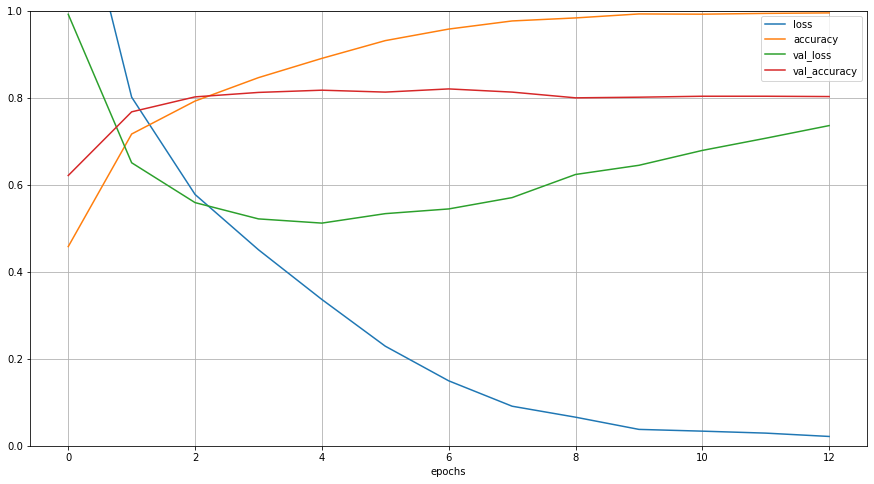

In [14]:
pd.DataFrame(textcnn.history.history).plot(figsize=(15,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel("epochs")
plt.show()

In [37]:
len(x_test)

1366

In [44]:
len(y_test)

1366

#### 测试集准确率

In [44]:
textcnn.evaluate(x_test,y_test)

              precision    recall  f1-score   support

          求助       0.81      0.77      0.79       244
        治安案件       0.84      0.76      0.80       225
          纠纷       0.86      0.94      0.89       568
          举报       0.76      0.63      0.69        35
        其它报警       0.61      0.58      0.59       209
        刑事案件       0.80      0.75      0.78        85

    accuracy                           0.81      1366
   macro avg       0.78      0.74      0.76      1366
weighted avg       0.80      0.81      0.80      1366



In [46]:
textcnn.single_predict("有人聚众赌博打牌") # 单句预测

('举报', 0.38402218)

In [47]:
textcnn.single_predict("有人聚众赌博打牌") # 单句预测

('举报', 0.38402218)

#### c.调整实验设置（超参数、网络结构），对比结果。

- 调整词向量维度为400，句长为300
- 调整模型结构，使用3个一维卷积，卷积核大小 kernel_size=[3,4,5]，每个卷积层有128 个卷积核
- 调整dropout层比例为0.6

In [49]:
config2 = Config(400,300)#词向量维度=400,句长为300
preprocessor2 = Preprocessor(config2)
x=preprocessor2.transform(x_doc)
x_test=preprocessor2.transform(x_test_doc)
x_train,x_valid,y_train, y_valid = train_test_split(x,y, test_size=0.2, random_state=42)

In [52]:
class TextCNN2(object):
    def __init__(self, config):
        self.config = config
        self.preprocessor = Preprocessor(config)
        self.class_name = {0:"求助" , 1:"治安案件", 2:"纠纷", 3:"举报",4: "其它报警",5:"刑事案件"}
    
    def build_model(self):
        # 模型架构搭建
        idx_input = tf.keras.layers.Input((self.config.max_seq_len,))
        input_embedding = tf.keras.layers.Embedding(len(self.preprocessor.token2idx),
                    self.config.embedding_dim,
                    input_length=self.config.max_seq_len,
                    mask_zero=True)(idx_input)
        convs = []
        for kernel_size in [ 3, 4, 5]:
            c = tf.keras.layers.Conv1D(128, kernel_size, activation='relu')(input_embedding)
            c = tf.keras.layers.GlobalMaxPooling1D()(c)
            convs.append(c)
        fea_cnn = tf.keras.layers.Concatenate()(convs)
        fea_cnn_dropout = tf.keras.layers.Dropout(rate=0.6)(fea_cnn)
        
        fea_dense = tf.keras.layers.Dense(64, activation='relu')(fea_cnn_dropout)
        output = tf.keras.layers.Dense(6, activation='softmax')(fea_dense)
        
        model = tf.keras.Model(inputs=idx_input, outputs=output)
        model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr = 0.001,decay =1e-2),
              metrics=['accuracy'])
        
        model.summary()
        
        self.model = model
    
    def fit(self, x_train, y_train, x_valid=None, y_valid=None, epochs=5, batch_size=128, callbacks=None, **kwargs):
        # 训练
        valid_data = None
        if x_valid is not None and y_valid is not None:
            valid_data = (x_valid, y_valid)

        self.history=self.model.fit(
            x=x_train,
            y=y_train,
            validation_data= valid_data,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            **kwargs
        )
        
    def evaluate(self, x_test, y_test):
        # 评估
        y_pred_probs = self.model.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=-1)
        result = classification_report(y_test, y_pred, target_names=['求助','治安案件','纠纷','举报','其它报警','刑事案件'])
        print(result)
        
        
    def single_predict(self, text):
        # 预测
        test=re.sub("[0-9]+|年|月|日|时|分|、|：||:|[*]|（.*?）|{.*?}|[.*?]|【.*?】", "",text)
        input_idx = self.preprocessor.transform([text])
        predict_prob = self.model.predict(input_idx)[0]
        predict_label_id = np.argmax(predict_prob)
        
        predict_label_name = self.class_name[predict_label_id]
        predict_label_prob = predict_prob[predict_label_id]
        
        return predict_label_name, predict_label_prob
    
    def load_model(self, ckpt_file):
        self.build_model()
        self.model.load_weights(ckpt_file)

In [53]:
textcnn2 = TextCNN2(config2)
textcnn2.build_model()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 300, 400)     6931600     input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 298, 128)     153728      embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 297, 128)     204928      embedding_8[0][0]                
______________________________________________________________________________________

In [54]:
# 定义early stop早停回调函数
patience = 3
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

# 定义checkpoint回调函数
checkpoint_prefix = './clean_checkpoints2/textcnn_imdb_ckpt'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

textcnn2.fit(x_train, y_train, x_valid, y_valid, epochs=50, callbacks=[early_stop, checkpoint_callback]) # 训练



Epoch 1/50
43/43 [==============================] - 8s 189ms/step - loss: 1.2925 - accuracy: 0.5064 - val_loss: 0.9243 - val_accuracy: 0.6750
Epoch 2/50
43/43 [==============================] - 8s 183ms/step - loss: 0.8037 - accuracy: 0.7078 - val_loss: 0.6608 - val_accuracy: 0.7679
Epoch 3/50
43/43 [==============================] - 8s 182ms/step - loss: 0.6101 - accuracy: 0.7862 - val_loss: 0.5790 - val_accuracy: 0.7943
Epoch 4/50
43/43 [==============================] - 9s 204ms/step - loss: 0.5126 - accuracy: 0.8224 - val_loss: 0.5527 - val_accuracy: 0.8031
Epoch 5/50
43/43 [==============================] - 8s 181ms/step - loss: 0.4412 - accuracy: 0.8517 - val_loss: 0.5374 - val_accuracy: 0.8104
Epoch 6/50
43/43 [==============================] - 8s 182ms/step - loss: 0.3926 - accuracy: 0.8687 - val_loss: 0.5311 - val_accuracy: 0.8119
Epoch 7/50
43/43 [==============================] - 8s 181ms/step - loss: 0.3476 - accuracy: 0.8861 - val_loss: 0.5167 - val_accuracy: 0.8177
Epoch 

In [55]:
textcnn2.evaluate(x_test,y_test)

              precision    recall  f1-score   support

          求助       0.83      0.77      0.80       244
        治安案件       0.85      0.78      0.81       225
          纠纷       0.86      0.94      0.90       568
          举报       0.76      0.63      0.69        35
        其它报警       0.60      0.57      0.59       209
        刑事案件       0.82      0.73      0.77        85

    accuracy                           0.81      1366
   macro avg       0.78      0.74      0.76      1366
weighted avg       0.80      0.81      0.80      1366



In [56]:
textcnn2.single_predict("有人聚众赌博打牌") # 单句预测

('举报', 0.441279)